# Homework 

The goal of this homework is to create a regression model for predicting housing prices (column 'median_house_value').

In this homework we'll again use the California Housing Prices dataset - the same one we used in homework 2 and 3.

You can take it from [Kaggle](https://www.kaggle.com/datasets/camnugent/california-housing-prices) or download using wget link mentioned below:

wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

/home/dc/Envs/ml-zoomcamp/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading Data

In [2]:
columns = [
'latitude', 'longitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 
'population','households', 'median_income', 'median_house_value', 'ocean_proximity'
]
df = pd.read_csv('housing.csv',usecols=columns)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


- Missing Values

In [3]:
df.isnull().sum() > 0

longitude             False
latitude              False
housing_median_age    False
total_rooms           False
total_bedrooms         True
population            False
households            False
median_income         False
median_house_value    False
ocean_proximity       False
dtype: bool

In [4]:
missing_columns = df.isnull().sum()[(df.isnull().sum() > 0)].index.tolist()
df[missing_columns] = df[missing_columns].fillna(0.0)
df.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

- Apply the log tranform to median_house_value.

<AxesSubplot:>

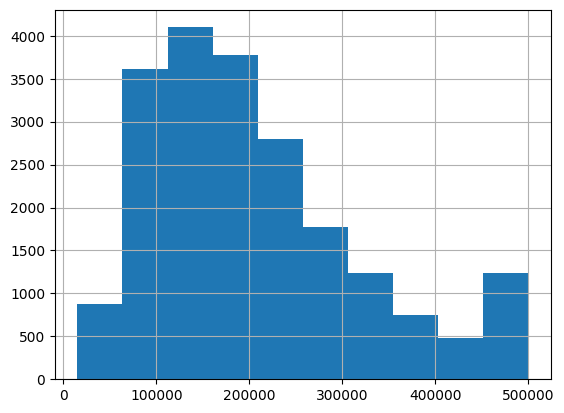

In [5]:
df.median_house_value.hist()

<AxesSubplot:>

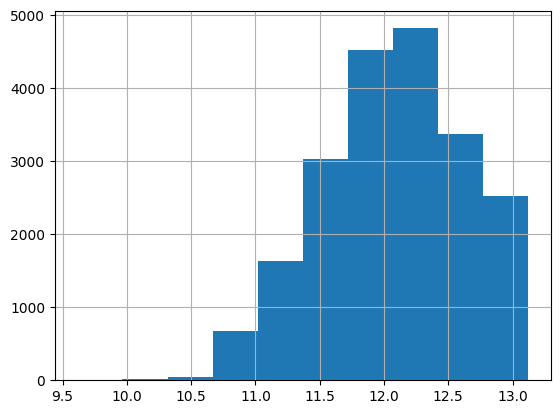

In [6]:
df['median_house_value'] = np.log1p(df['median_house_value'])
df.median_house_value.hist()

- Do train/validation/test split with 60%/20%/20% distribution.
- Use the train_test_split function and set the random_state parameter to 1.

In [7]:
df_full_train,df_test = train_test_split(df,test_size=0.2,random_state=1)
df_train,df_val = train_test_split(df_full_train,test_size=0.25,random_state=1)

In [8]:
print(f"Len of df_full_train : {len(df_full_train)}")
print(f"Len of df_train : {len(df_train)}")
print(f"Len of df_val : {len(df_val)}")
print(f"Len of df_test : {len(df_test)}")

Len of df_full_train : 16512
Len of df_train : 12384
Len of df_val : 4128
Len of df_test : 4128


In [9]:
y_train = df_train.median_house_value
y_val = df_val.median_house_value
y_test = df_test.median_house_value

In [10]:
del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

- Use DictVectorizer to turn the dataframe into matrices.

In [11]:
X_train_dict = df_train.to_dict(orient='records')
X_val_dict = df_val.to_dict(orient='records')
X_test_dict = df_test.to_dict(orient='records')

In [12]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(X_train_dict)

In [13]:
X_val = dv.transform(X_val_dict)
X_test = dv.transform(X_test_dict)

## Q1 

- Let's train a decision tree regressor to predict the median_house_value variable.

- Train a model with max_depth=1.
- Which feature is used for splitting the data?

   - ocean_proximity=INLAND
   - total_rooms
   - latitude
   - population

In [14]:
dtr = DecisionTreeRegressor(max_depth=1)
dtr.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=1)

In [15]:
print(export_text(dtr,feature_names=list(dv.get_feature_names_out())))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



## Q2

- Train a random forest model with these parameters:

  -  n_estimators=10
  -  random_state=1
  -  n_jobs=-1 (optional - to make training faster)

What's the RMSE of this model on validation?

- 0.05
- 0.25
- 0.55
- 0.85


In [16]:
rfr = RandomForestRegressor(n_estimators=10,n_jobs=-1,random_state=1)
rfr.fit(X_train,y_train)
y_pred = rfr.predict(X_val)
np.sqrt(mean_squared_error(y_val,y_pred)).round(2)

0.25

## Q3 

Now let's experiment with the n_estimators parameter

- Try different values of this parameter from 10 to 200 with step 10.
- Set random_state to 1.
- Evaluate the model on the validation dataset.

After which value of n_estimators does RMSE stop improving?

- 10
- 55
- 75
- 150

<AxesSubplot:xlabel='n_estimators'>

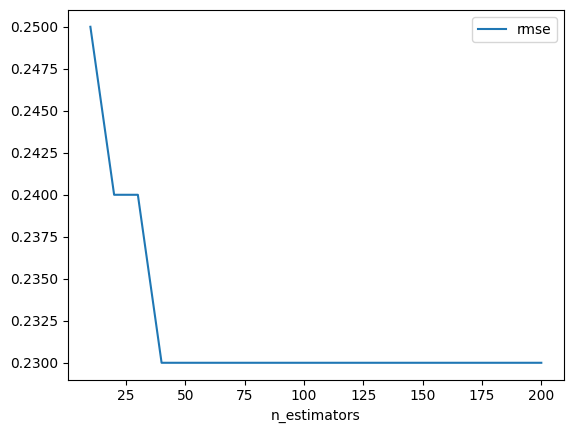

In [17]:
n_estimators = np.arange(10,210,step=10)
scores = []
for n in n_estimators:
    rfr = RandomForestRegressor(n_estimators=n,n_jobs=-1,random_state=1)
    rfr.fit(X_train,y_train)
    y_pred = rfr.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val,y_pred)).round(2)
    scores.append({'n_estimators':n,'rmse':score})

df_scores = pd.DataFrame(scores)
df_scores.plot(x='n_estimators',y='rmse')

In [18]:
depths =  [10, 15, 20, 25]
n_estimators = np.arange(10,210,step=10)
scores = []

for d in depths:
    for n in n_estimators:
        rfr = RandomForestRegressor(max_depth = d, n_estimators=n,n_jobs=-1,random_state=1)
        rfr.fit(X_train,y_train)
        y_pred = rfr.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val,y_pred)).round(2)
        scores.append({'max_depth':d,'n_estimators':n,'rmse':score})
        
df_scores = pd.DataFrame(scores)

In [19]:
df_scores.groupby('max_depth').rmse.describe()

,count,mean,std,min,25%,50%,75%,max
max_depth,,,,,,,,
10,20.0,0.2500,0.000000,0.25,0.25,0.25,0.25,0.25
15,20.0,0.2320,0.004104,0.23,0.23,0.23,0.23,0.24
20,20.0,0.2325,0.005501,0.23,0.23,0.23,0.23,0.25
25,20.0,0.2315,0.003663,0.23,0.23,0.23,0.23,0.24


<AxesSubplot:xlabel='max_depth', ylabel='rmse'>

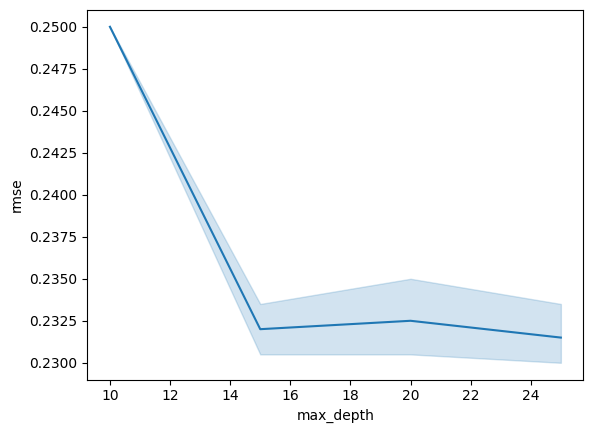

In [20]:
sns.lineplot(x='max_depth',y='rmse',data=df_scores)

## Q5

- Train the model with these parametes:
    - n_estimators=10,
    - max_depth=20,
    - random_state=1,
    - n_jobs=-1 (optional)

- Get the feature importance information from this model

- What's the most important feature?

    - total_rooms
    - median_income
    - total_bedrooms
    - longitude



In [21]:
rfr = RandomForestRegressor(max_depth = 20, n_estimators=10,n_jobs=-1,random_state=1)
rfr.fit(X_train,y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [22]:
f_importances = pd.Series(rfr.feature_importances_.round(4),index=dv.get_feature_names_out())
f_importances.sort_values(ascending=False)

median_income                 0.3637
ocean_proximity=INLAND        0.3109
latitude                      0.1015
longitude                     0.0963
housing_median_age            0.0329
population                    0.0296
total_rooms                   0.0218
total_bedrooms                0.0182
households                    0.0171
ocean_proximity=NEAR OCEAN    0.0042
ocean_proximity=<1H OCEAN     0.0029
ocean_proximity=ISLAND        0.0004
ocean_proximity=NEAR BAY      0.0004
dtype: float64

## Q6 

Now let's train an XGBoost model! For this question, we'll tune the eta parameter:

- Create DMatrix for train and validation
- Create a watchlist
- Train a model with these parameters for 100 rounds:


In [23]:
features = list(dv.get_feature_names_out())
features = [f.replace('<','less') for f in features]
dtrain = xgb.DMatrix(X_train,label=y_train,feature_names=features)
dval = xgb.DMatrix(X_val,label=y_val,feature_names=features)

watch_list = [(dtrain,'train'),(dval,'val')] 

In [24]:
etas = [0.3,0.1,0.01]
scores = pd.DataFrame()
for eta in etas:
    xgb_params = {
    'eta': eta, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

    evals_result = {}
    model = xgb.train(xgb_params,dtrain=dtrain,num_boost_round=100,
                    evals_result=evals_result,verbose_eval=False,evals=watch_list)
    df_scores = pd.DataFrame([evals_result['train']['rmse'],evals_result['val']['rmse']]).T
    df_scores.columns = ['train_rmse','val_rmse']
    df_scores['eta'] = eta 
    scores = pd.concat([scores,df_scores])

In [25]:
scores.groupby('eta').val_rmse.describe()

,count,mean,std,min,25%,50%,75%,max
eta,,,,,,,,
0.01,100.0,7.294183,2.102219,4.264961,5.461396,6.996746,8.966232,11.492254
0.10,100.0,1.195462,2.105760,0.230542,0.235186,0.254273,0.826368,10.449375
0.30,100.0,0.480036,1.065971,0.225785,0.227672,0.231148,0.241359,8.132449


<AxesSubplot:ylabel='val_rmse'>

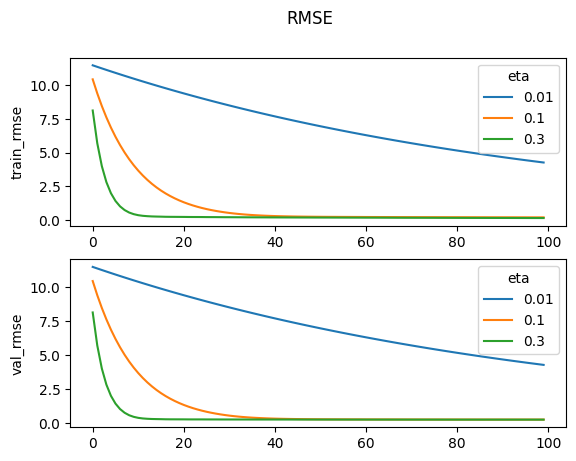

In [26]:
fig,ax=plt.subplots(nrows=2)
fig.suptitle("RMSE")
sns.lineplot(x=scores.index,y=scores.train_rmse,hue=scores.eta,palette='tab10',ax=ax[0])
sns.lineplot(x=scores.index,y=scores.val_rmse,hue=scores.eta,palette='tab10',ax=ax[1])